In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
import keras.backend as K

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
!ls -l trained_model/

合計 105972
-rw-rw-r-- 1 uchiumi uchiumi  7264736  6月 10 11:56 trained_cnn_v0.h5
-rw-rw-r-- 1 uchiumi uchiumi  4965880  6月  9 23:35 vae_mnist.h5
-rw-rw-r-- 1 uchiumi uchiumi 23147968  6月 11 02:36 vae_stl10_epoch100.h5
-rw-rw-r-- 1 uchiumi uchiumi 73127096  6月 11 14:02 vgg16_stl10_v0.h5


In [15]:
from tensorflow.python.keras import utils
from keras.datasets import mnist

batch_size = 128
original_dim = 784
latent_dim = 10
intermediate_dim = 256
epochs = 100

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
!nvidia-smi

Tue Jun 23 19:25:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
| 36%   47C    P8    11W / 200W |    184MiB /  8118MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
with keras.utils.CustomObjectScope({'GlorotUniform': keras.initializers.glorot_uniform()}):
    model = keras.models.load_model('trained_model/vae_mnist.h5', compile=False)
    model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           2570        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           2570        dense_1[0][0]                    
_____________________________________

# Eval

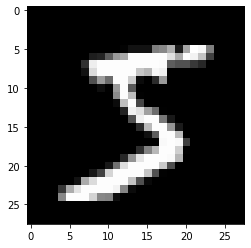

In [6]:
idx=0
plt.imshow(x_train[idx].reshape(28,28), "gray")
plt.show()

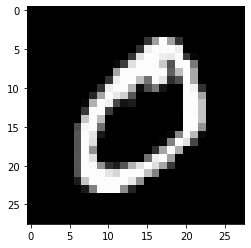

In [7]:
idx=1
plt.imshow(x_train[idx].reshape(28,28), "gray")
plt.show()

# Experiments 0623

In [39]:
def calc_eig(matrix):
    eig_values, eig_vectors = np.linalg.eigh(matrix)
    
    eig_values = eig_values.astype(np.float32)
    eig_vectors = eig_vectors.astype(np.float32)

    for i in range(len(eig_vectors)):
        eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)

    return eig_values, eig_vectors

In [40]:
def calc_max_eig_vector(matrix):
    eig_values, eig_vectors = np.linalg.eigh(matrix)
    
    eig_values = eig_values.astype(np.float32)
    eig_vectors = eig_vectors.astype(np.float32)

    for i in range(len(eig_vectors)):
        eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)

    max_eig_vector = eig_vectors[np.argmax(eig_values)]
    return max_eig_vector

In [25]:
idx = 1
batch_size=100

x_true = x_train[idx:idx+batch_size].reshape(batch_size, 784)
y_true = x_true
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})

In [31]:
batch_size=250
gradients = np.zeros((10, 784))

for i, idx in enumerate(tqdm(range(int(len(x_test)/batch_size)))):
    x_true = x_train[idx:idx+batch_size].reshape(batch_size, 784)
    y_true = x_true
    y_pred = model.output

    init = tf.global_variables_initializer()
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    get_grad = K.gradients(loss, model.input)

    sess = K.get_session()
    sess.run(init)
    gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})
    gradient = np.squeeze(gradient.mean(axis=0))
    
    gradients[y_test[idx]] = 1/(i+1)*gradient + i/(i+1)*gradients[y_test[idx]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [34]:
hessian_matrices = np.zeros((10, 784, 784))
for c in range(10):
    hessian_matrices[c] = np.outer(gradient[c], gradient[c])

In [41]:
max_eigs = np.zeros((10, 784))
for c in range(10):
    max_eigs[c] = calc_max_eig_vector(hessian_matrices[c])

max_eig


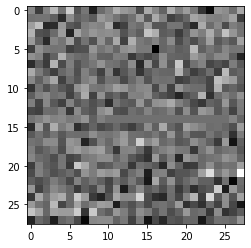

label 4
original


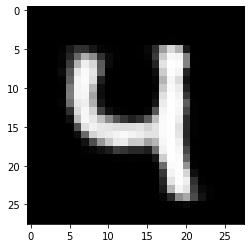

(original + max_eig) / 2


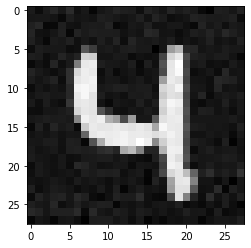

(original + max_eig) / 2 - original


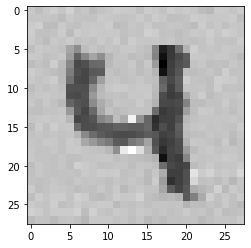

(original + max_eig) / 2 - original


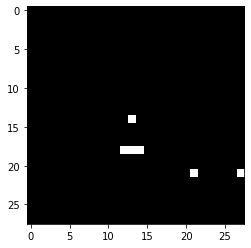

recon. (original + max_eig)


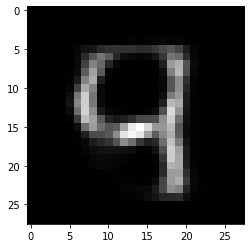

In [117]:
idx=3500

eig_vec = max_eigs[y_test[idx]]
x_pred = model.predict(x_test[idx].reshape(1, 784))
x_pred_mov = model.predict(((x_test[idx] + eig_vec)/2).reshape(1, 784))

print("max_eig")
plt.imshow(eig_vec.reshape(28,28), "gray")
plt.show()

print("label", y_test[idx])
print("original")
plt.imshow(x_pred.reshape(28,28), "gray")
plt.show()

print("(original + max_eig) / 2")
plt.imshow(((x_test[idx] + eig_vec)/2).reshape(28,28), "gray")
plt.show()

print("(original + max_eig) / 2 - original")
plt.imshow(((x_test[idx] + eig_vec)/2 - x_pred).reshape(28,28), "gray")
plt.show()

print("(original + max_eig) / 2 - original")
plt.imshow((np.where(((x_test[idx] + eig_vec)/2 - x_pred) > 0.065, 1, 0)).reshape(28,28), "gray")
plt.show()

print("recon. (original + max_eig)")
plt.imshow(x_pred_mov.reshape(28,28), "gray")
plt.show()